In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

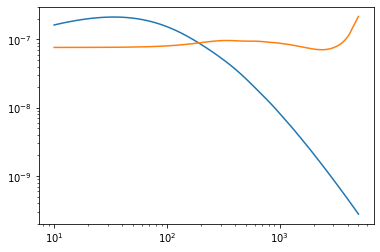

In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [4]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
I_kappa = d_delta_integral(f_KLIM_windowed, f_Kkappa) #[kJy / sr ] [Mpc]

In [5]:
from scipy.integrate import trapezoid, simpson, quad_vec
from scipy.interpolate import interp1d


In [6]:
from tqdm import trange, tqdm

In [7]:
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

In [8]:
chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)

13


In [9]:
Lambdas = np.logspace(-5, 0, 50)

In [10]:
_chis = chis_resample[window]

In [11]:
SNR2_per_mode = {}
SNR2_per_mode_full = {}
SNR2_per_mode_sanity = {}

integrand =  I_kappa**2 / (1/chis_resample**2)
SNR2_per_mode[0.0] = trapezoid(x = chis_resample, y = integrand)/(ClKK + f_N0(ells)) 
SNR2_per_mode_full[0.0] = SNR2_per_mode[0.0]
SNR2_per_mode_sanity[0.0] = SNR2_per_mode[0.0]

for Lambda in tqdm(Lambdas):
    try:
        IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
        IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

        integrand =  IHi_kappa**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]

        # total integral has unit #[kJy^2 / sr^2][Mpc^3] 
        SNR2_per_mode[Lambda] = simpson(x = chis_resample[window], 
                                        y = integrand[:,window])/(ClKK + f_N0(ells)) 


    #     eIeI, eLOeLO, eIeLO, eLOeI = get_eHIeHI(chimin, chimax, Lambda)
        oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
        eIeI = np.load(oup_fname + 'eIeI.npy')
        eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
        eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
        eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )


        eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI
        IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

        D = np.diag(_chis**2)
        L = np.linalg.cholesky(eHIeHI @ D)
        y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
        x = np.linalg.solve(L.T, y) 
        SNR2_per_mode_full[Lambda] = np.einsum('ij, ji->i', IHi_kappa_windowed, x) / (ClKK + f_N0(ells))



        L = np.linalg.cholesky(eIeI * _chis ** 2)
        y = np.linalg.solve(L, IHi_kappa_windowed.T )
        x = np.linalg.solve(L.T, y) 
        SNR2_per_mode_sanity[Lambda] = np.einsum('ij, ji->i', _chis**2 * IHi_kappa_windowed, x) / (ClKK + f_N0(ells))
    except:
        print('skipping', Lambda)

 86%|████████▌ | 43/50 [00:11<00:01,  5.10it/s]

skipping 0.15264179671752334
skipping 0.19306977288832497


 90%|█████████ | 45/50 [00:11<00:00,  6.70it/s]

skipping 0.244205309454865
skipping 0.30888435964774846


 94%|█████████▍| 47/50 [00:12<00:00,  7.34it/s]

skipping 0.3906939937054621
skipping 0.49417133613238384


 96%|█████████▌| 48/50 [00:12<00:00,  7.75it/s]

skipping 0.6250551925273976
skipping 0.7906043210907702


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]

skipping 1.0


In [12]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [13]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

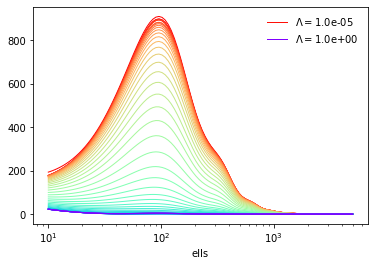

In [14]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

(0.0, 1000.0)

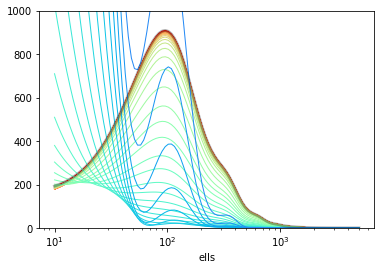

In [15]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_sanity:
    label = r'$\Lambda=$%.1e'%(Lambda)
    label = None
    plt.plot(ells, SNR2_per_mode_full[Lambda], label=label, lw = 1)
    
plt.plot(ells, SNR2_per_mode[0.0], label=label, lw = 3, c='k', alpha = 0.3)
plt.xscale('log')
plt.xlabel('ells')
plt.ylim(0,1000)

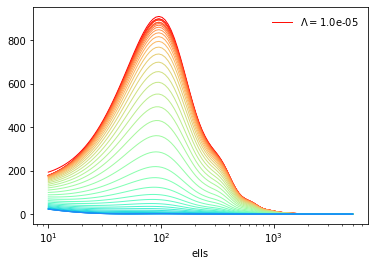

In [16]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode_sanity[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

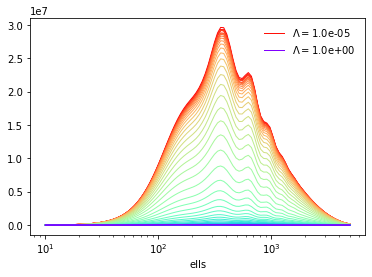

In [17]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

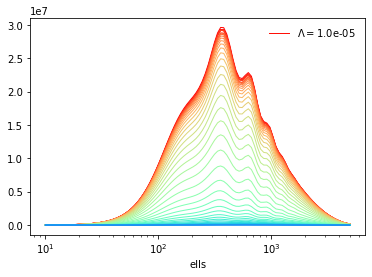

In [18]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_sanity[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

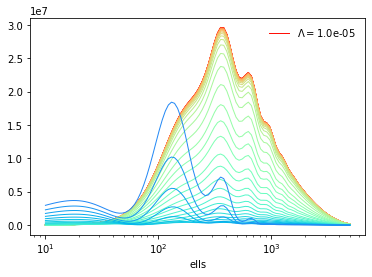

In [19]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [20]:
plt.show()
plt.rcParams['text.usetex'] = True

In [21]:
SNR2_per_Omega_per_invPei = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_full = np.zeros_like(Lambdas)
SNR2_per_Omega_per_invPei_sanity = np.zeros_like(Lambdas)

for Lambda_idx in range(len(Lambdas)):
    Lambda = Lambdas[Lambda_idx]
    #[kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    summand = SNR2_per_mode[Lambda] * ells ** 2 
    
    # [kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    SNR2_per_Omega_per_invPei[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)
    
    SNR2_per_Omega_per_invPei_sanity[Lambda_idx] = trapezoid(x = np.log(ells), 
                                       y = SNR2_per_mode_sanity[Lambda] * ells ** 2 / 2 / np.pi)

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

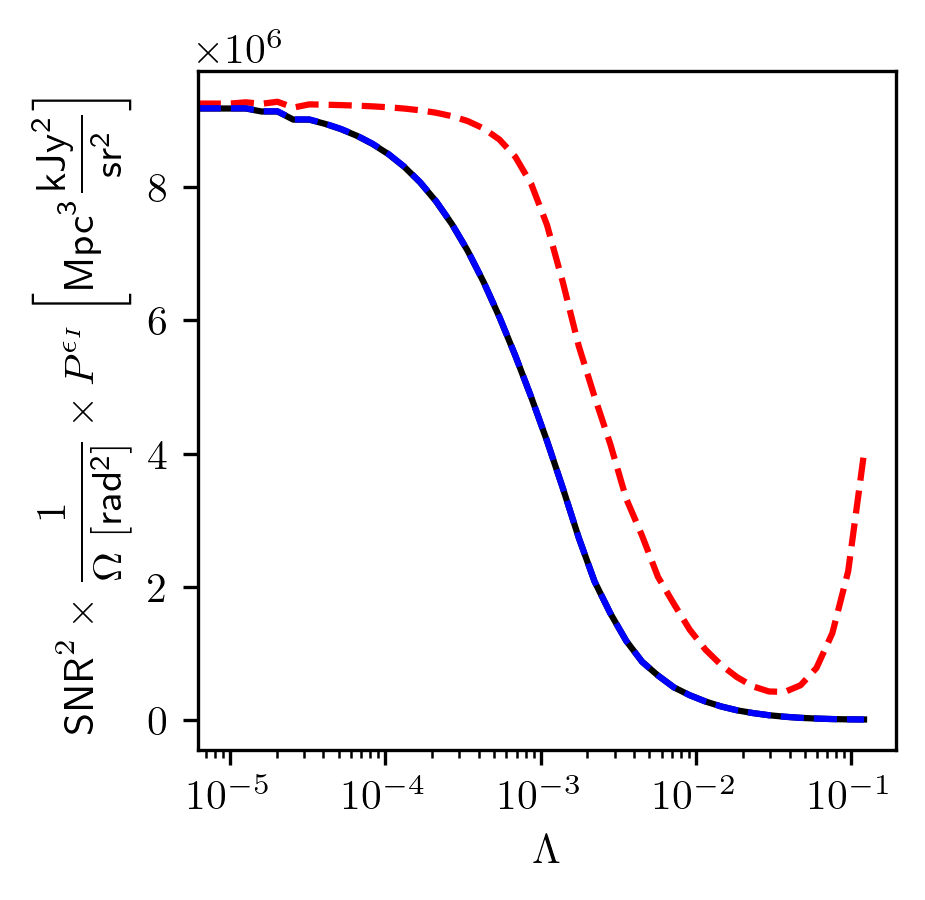

In [22]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, (SNR2_per_Omega_per_invPei), c='k')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_full), 'r--')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei_sanity), 'b--')

plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

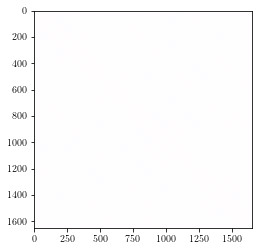

In [23]:
vminmax = np.max(np.abs(eHIeHI))
plt.imshow(eHIeHI, vmin = -vminmax, vmax = vminmax, cmap = 'seismic')

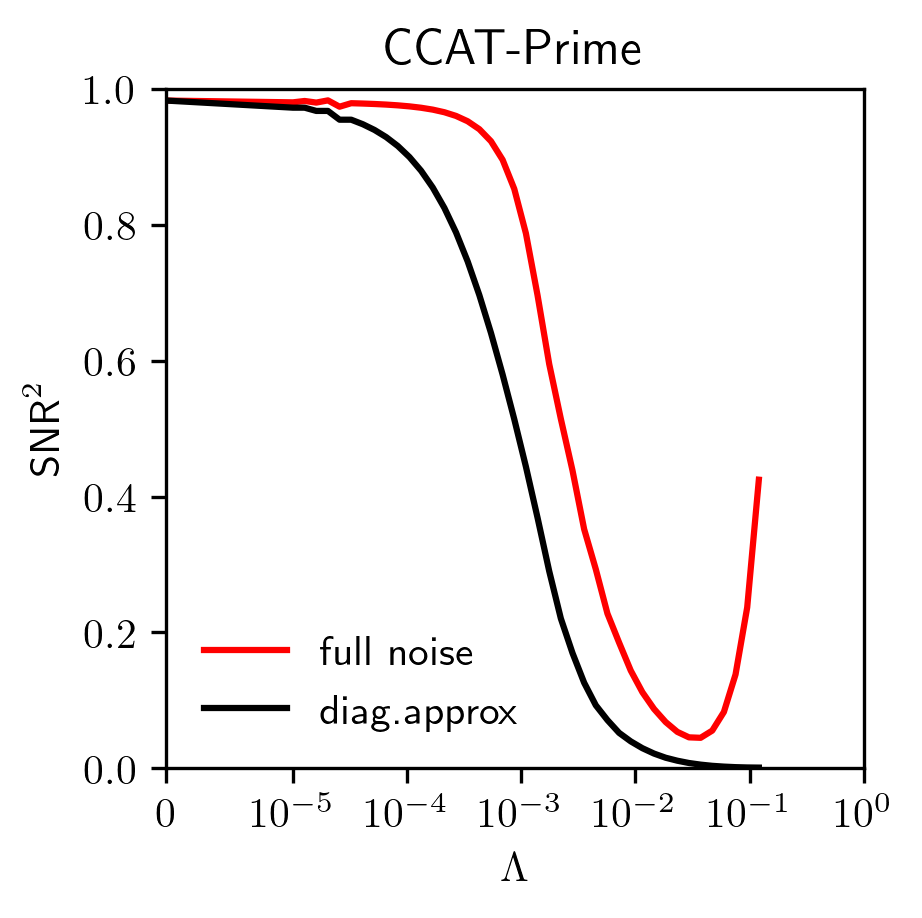

In [24]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

# plt.plot(Lambdas, 
#          (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
#          'b--',
#         label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e0)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.legend(frameon=False)

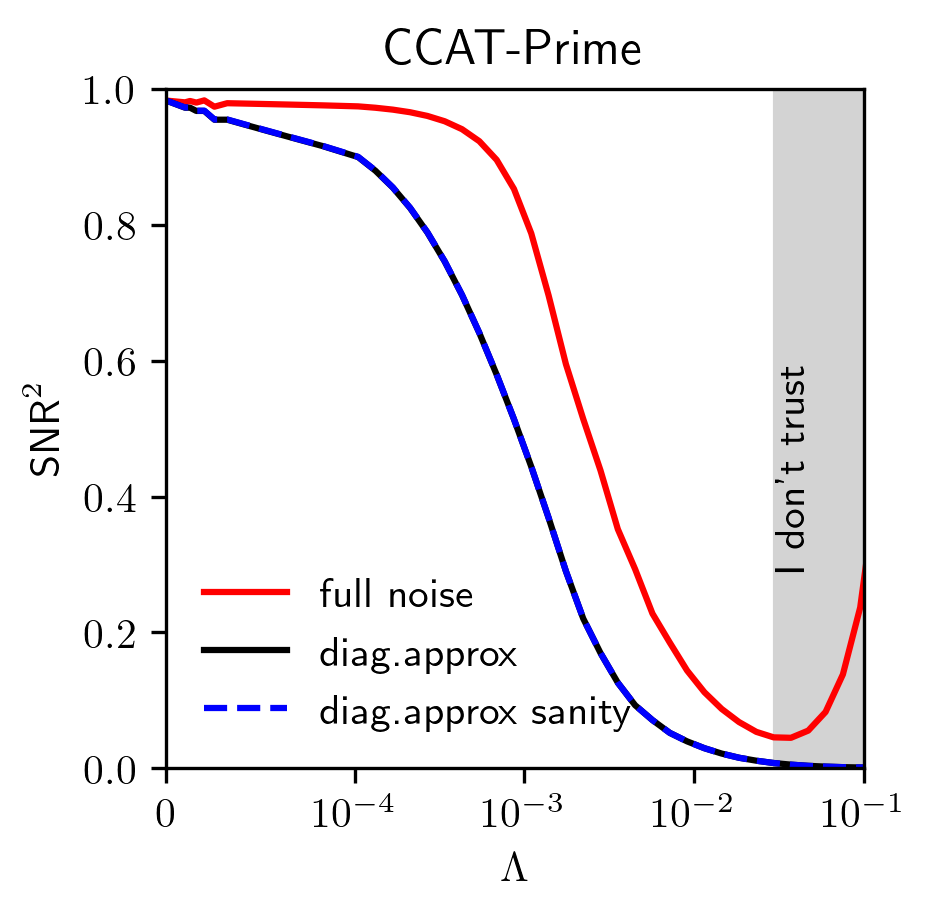

In [25]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
         'b--',
        label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-4)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.fill_between([3e-2, 1e-1], [0, 0], [100, 100], color='lightgrey')
plt.text(3e-2, 0.3, "I don't trust", rotation=90)
plt.legend(frameon=False)

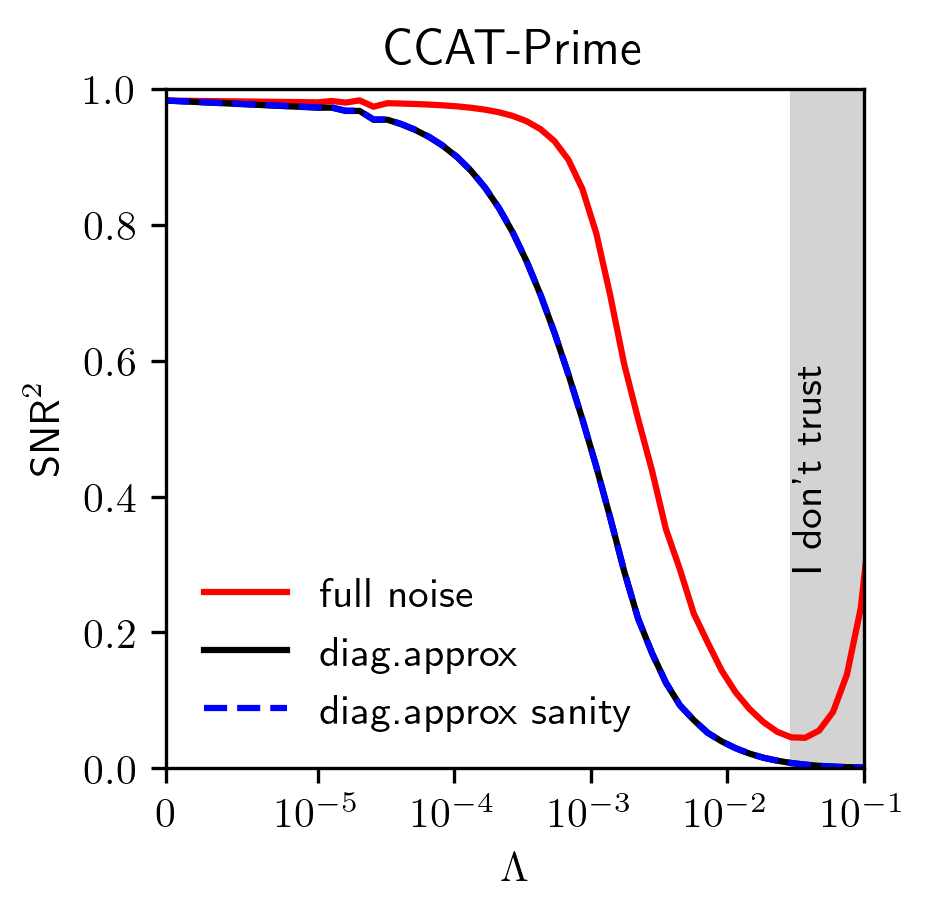

In [29]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r-',
        label='full noise')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         c='k',
        label='diag.approx')

plt.plot(Lambdas, 
         (SNR2_per_Omega_per_invPei_sanity * Omega_field / Pei), 
         'b--',
        label='diag.approx sanity')


plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')
plt.fill_between([3e-2, 1e-1], [0, 0], [100, 100], color='lightgrey')
plt.text(3e-2, 0.3, "I don't trust", rotation=90)
plt.legend(frameon=False)